In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre

def feature_transform(lines):
    X = []
    truth = []

    for line in lines:
        values = list(map(float, line.split()))
        label = values[0]
        values = values[1:]  # Remove label
        assert(len(values) == 256)
       
        horiz_sym = 0
        vert_sym = 0
        for i in range(16):
            for j in range(8):
                horiz_sym += abs(values[i*16 + j] - values[i*16 + 15-j])
        for i in range(8):
            for j in range(16):
                vert_sym += abs(values[i*16 + j] - values[(15-i)*16 + j])
        horiz_sym = horiz_sym / 128.0
        vert_sym = vert_sym / 128.0
        
        X.append([1, vert_sym, horiz_sym])
        truth.append(1 if label == 1.0 else -1)

    return np.array(X), np.array(truth)

def normalize(X):
    f1 = []
    f2 = []

    for item in X:
        f1.append(item[1])
        f2.append(item[2])

    shift1 = (max(f1) + min(f1)) / 2
    shift2 = (max(f2) + min(f2)) / 2
    scale1 = (max(f1) - min(f1)) / 2
    scale2 = (max(f2) - min(f2)) / 2

    for i in range(len(X)):
        X[i][1] = (X[i][1] - shift1) / scale1
        X[i][2] = (X[i][2] - shift2) / scale2

    return X

# Legendre Transform
def L(k, x):
    if k == 0:
        return 1
    if k == 1:
        return x
    
    term_1 = (2*k - 1) / k * x * L(k - 1, x)
    term_2 = (k - 1)  / k * L(k - 2, x)
    return term_1 - term_2

def polynomial_transform(X):
    n_samples = len(X)
    features = []

    for i in range(n_samples):
        x_1, x_2 = X[i][1], X[i][2]  # Skip bias term
        row_features = []
        row_features.append(1)
        # First-order terms
        row_features.append(L(1, x_1))
        row_features.append(L(1, x_2))
        # Second-order terms
        row_features.append(L(2, x_1))
        row_features.append(L(1, x_1) * L(1, x_2))
        row_features.append(L(2, x_2))
        # Third-order terms
        row_features.append(L(3, x_1))
        row_features.append(L(2, x_1) * L(1, x_2))
        row_features.append(L(1, x_1) * L(2, x_2))
        row_features.append(L(3, x_2))
        # Fourth-order terms
        row_features.append(L(4, x_1))
        row_features.append(L(3, x_1) * L(1, x_2))
        row_features.append(L(2, x_1) * L(2, x_2))
        row_features.append(L(1, x_1) * L(3, x_2))
        row_features.append(L(4, x_2))
        # Fifth-order terms
        row_features.append(L(5, x_1))
        row_features.append(L(4, x_1) * L(1, x_2))
        row_features.append(L(3, x_1) * L(2, x_2))
        row_features.append(L(2, x_1) * L(3, x_2))
        row_features.append(L(1, x_1) * L(4, x_2))
        row_features.append(L(5, x_2))
        # Sixth-order terms
        row_features.append(L(6, x_1))
        row_features.append(L(5, x_1) * L(1, x_2))
        row_features.append(L(4, x_1) * L(2, x_2))
        row_features.append(L(3, x_1) * L(3, x_2))
        row_features.append(L(2, x_1) * L(4, x_2))
        row_features.append(L(1, x_1) * L(5, x_2))
        row_features.append(L(6, x_2))
        # Seventh-order terms
        row_features.append(L(7, x_1))
        row_features.append(L(6, x_1) * L(1, x_2))
        row_features.append(L(5, x_1) * L(2, x_2))
        row_features.append(L(4, x_1) * L(3, x_2))
        row_features.append(L(3, x_1) * L(4, x_2))
        row_features.append(L(2, x_1) * L(5, x_2))
        row_features.append(L(1, x_1) * L(6, x_2))
        row_features.append(L(7, x_2))
        # Eighth-order terms
        row_features.append(L(8, x_1))
        row_features.append(L(7, x_1) * L(1, x_2))
        row_features.append(L(6, x_1) * L(2, x_2))
        row_features.append(L(5, x_1) * L(3, x_2))
        row_features.append(L(4, x_1) * L(4, x_2))
        row_features.append(L(3, x_1) * L(5, x_2))
        row_features.append(L(2, x_1) * L(6, x_2))
        row_features.append(L(1, x_1) * L(7, x_2))
        row_features.append(L(8, x_2))

        features.append(row_features)

    return np.array(features)

def calculate_e_in(X, truth, weights):
    e_in = 0
    for x, truth_value in zip(X, truth):
        prediction = np.sign(np.dot(weights, x))
        prediction = int(prediction)
        if prediction != truth_value:
            e_in += 1
    return e_in / len(X)

def linear_regression(X, truth, Lambda=0):

    X_reg = np.dot(X.T, X) + Lambda * np.eye(X.shape[1])
    X_psuedo_inv = np.dot(np.linalg.inv(X_reg), X.T)
    weights = np.dot(X_psuedo_inv, truth)

    return weights

def plot_decision_boundary(X, truth, weights, show_data=True):
    
    plt.figure(figsize=(10, 6))
    
    vert_sym = X[:, 1]
    horiz_sym = X[:, 2]
    
    if show_data:
        plt.scatter(vert_sym[truth == 1], horiz_sym[truth == 1], 
                   color='blue', marker='o', label='1', alpha=0.5, s=50)
        plt.scatter(vert_sym[truth == -1], horiz_sym[truth == -1], 
                   color='red', marker='x', label='5', alpha=0.5, s=50)
    
    x_vals = np.linspace(min(vert_sym), max(vert_sym), 100)
    y_vals = -(weights[1] * x_vals + weights[0]) / weights[2]
    plt.plot(x_vals, y_vals, label='Decision Boundary', color='black', linewidth=2)
    
    plt.xlabel('Vertical Symmetry')
    plt.ylabel('Horizontal Symmetry')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_eighth_order_decision_boundary(X, truth, weights, show_data=True):
    plt.figure(figsize=(10, 6))
    
    vert_sym = X[:, 1]
    horiz_sym = X[:, 2]
    
    if show_data:
        plt.scatter(vert_sym[truth == 1], horiz_sym[truth == 1], 
                   color='blue', marker='o', label='1', alpha=0.5, s=50)
        plt.scatter(vert_sym[truth == -1], horiz_sym[truth == -1], 
                   color='red', marker='x', label='Other', alpha=0.5, s=50)
    
    # Create a fine mesh grid
    x_min, x_max = min(vert_sym) - 0.1, max(vert_sym) + 0.1
    y_min, y_max = min(horiz_sym) - 0.1, max(horiz_sym) + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    
    # Create feature matrix for grid points
    grid_points = []
    for i in range(xx.ravel().shape[0]):
        x_1, x_2 = xx.ravel()[i], yy.ravel()[i]
        
        # Match the exact same feature construction as in polynomial_transform
        features = [1]  # bias term
        # First-order terms
        features.append(L(1, x_1))
        features.append(L(1, x_2))
        # Second-order terms
        features.append(L(2, x_1))
        features.append(L(1, x_1) * L(1, x_2))
        features.append(L(2, x_2))
        # Third-order terms
        features.append(L(3, x_1))
        features.append(L(2, x_1) * L(1, x_2))
        features.append(L(1, x_1) * L(2, x_2))
        features.append(L(3, x_2))
        # Fourth-order terms
        features.append(L(4, x_1))
        features.append(L(3, x_1) * L(1, x_2))
        features.append(L(2, x_1) * L(2, x_2))
        features.append(L(1, x_1) * L(3, x_2))
        features.append(L(4, x_2))
        # Fifth-order terms
        features.append(L(5, x_1))
        features.append(L(4, x_1) * L(1, x_2))
        features.append(L(3, x_1) * L(2, x_2))
        features.append(L(2, x_1) * L(3, x_2))
        features.append(L(1, x_1) * L(4, x_2))
        features.append(L(5, x_2))
        # Sixth-order terms
        features.append(L(6, x_1))
        features.append(L(5, x_1) * L(1, x_2))
        features.append(L(4, x_1) * L(2, x_2))
        features.append(L(3, x_1) * L(3, x_2))
        features.append(L(2, x_1) * L(4, x_2))
        features.append(L(1, x_1) * L(5, x_2))
        features.append(L(6, x_2))
        # Seventh-order terms
        features.append(L(7, x_1))
        features.append(L(6, x_1) * L(1, x_2))
        features.append(L(5, x_1) * L(2, x_2))
        features.append(L(4, x_1) * L(3, x_2))
        features.append(L(3, x_1) * L(4, x_2))
        features.append(L(2, x_1) * L(5, x_2))
        features.append(L(1, x_1) * L(6, x_2))
        features.append(L(7, x_2))
        # Eighth-order terms
        features.append(L(8, x_1))
        features.append(L(7, x_1) * L(1, x_2))
        features.append(L(6, x_1) * L(2, x_2))
        features.append(L(5, x_1) * L(3, x_2))
        features.append(L(4, x_1) * L(4, x_2))
        features.append(L(3, x_1) * L(5, x_2))
        features.append(L(2, x_1) * L(6, x_2))
        features.append(L(1, x_1) * L(7, x_2))
        features.append(L(8, x_2))
        
        grid_points.append(features)
    
    # Calculate decision function values
    Z = np.dot(grid_points, weights)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contour(xx, yy, Z, levels=[0], colors='green', linewidths=2)
    plt.contourf(xx, yy, Z > 0, alpha=0.1, colors=['red', 'blue'])
    
    plt.xlabel('Vertical Symmetry')
    plt.ylabel('Horizontal Symmetry')
    plt.title('8th Order Legendre Polynomial Decision Boundary')
    plt.legend()
    plt.grid(True)
    plt.show()

E_in: 0.02
E_test: 0.013891975994665481


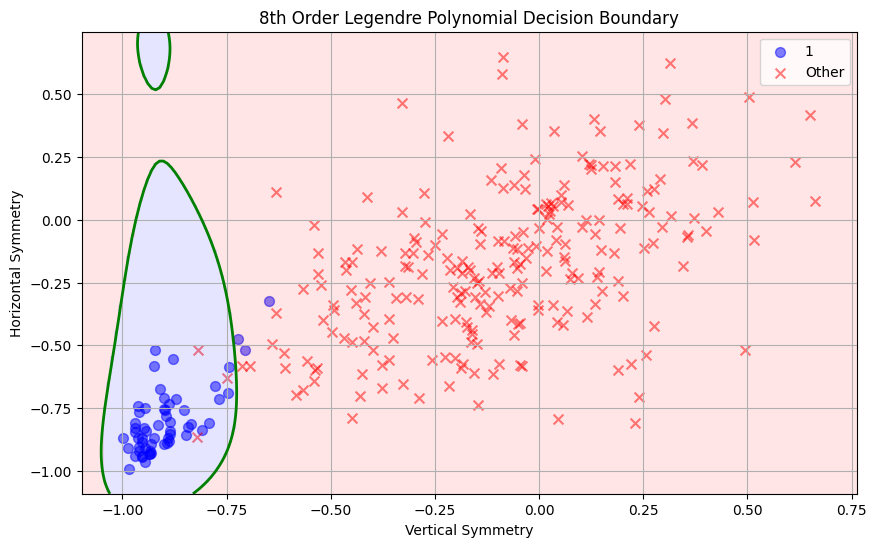

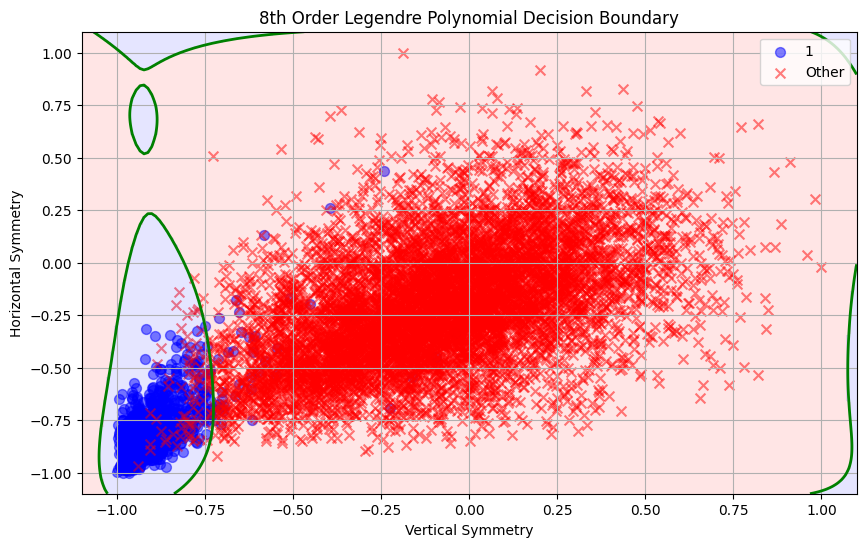

In [4]:
train_input_file = 'combined_ZipDigits.txt'
with open(train_input_file, 'r') as f:
    data = f.readlines()

# Feature transfrom and Normalization
X, truth_full = feature_transform(data)
X = normalize(X)

np.random.seed(30) # To make data reproducible across different lambdas
# Splitting data for training and testing
indices = np.random.choice(X.shape[0], size=300, replace=False) # Randomly generates 300 indices
D = X[indices] # Selects 300 random data points for training
truth = truth_full[indices]

D_test = np.delete(X, indices, axis=0)
truth_test = np.delete(truth_full, indices)

# Polynomial Transform
Z = polynomial_transform(D)
Z_test = polynomial_transform(D_test)

# Training
weights = linear_regression(Z, truth, Lambda=1.26)

# Printing Results
e_in = calculate_e_in(Z, truth, weights)
e_test = calculate_e_in(Z_test, truth_test, weights)
print('E_in:', e_in)
print('E_test:', e_test)
plot_eighth_order_decision_boundary(D, truth, weights)
plot_eighth_order_decision_boundary(D_test, truth_test, weights)

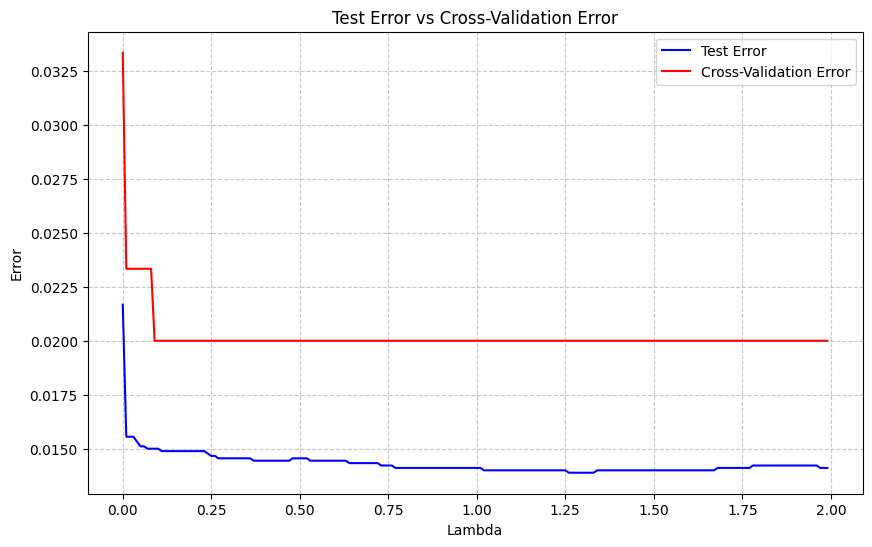

Lambda: 0, Test Error: 0.0217, Cross-Validation Error: 0.0333
Lambda: 0.01, Test Error: 0.0156, Cross-Validation Error: 0.0233
Lambda: 0.02, Test Error: 0.0156, Cross-Validation Error: 0.0233
Lambda: 0.03, Test Error: 0.0156, Cross-Validation Error: 0.0233
Lambda: 0.04, Test Error: 0.0153, Cross-Validation Error: 0.0233
Lambda: 0.05, Test Error: 0.0151, Cross-Validation Error: 0.0233
Lambda: 0.060000000000000005, Test Error: 0.0151, Cross-Validation Error: 0.0233
Lambda: 0.07, Test Error: 0.0150, Cross-Validation Error: 0.0233
Lambda: 0.08, Test Error: 0.0150, Cross-Validation Error: 0.0233
Lambda: 0.09, Test Error: 0.0150, Cross-Validation Error: 0.0200
Lambda: 0.09999999999999999, Test Error: 0.0150, Cross-Validation Error: 0.0200
Lambda: 0.10999999999999999, Test Error: 0.0149, Cross-Validation Error: 0.0200
Lambda: 0.11999999999999998, Test Error: 0.0149, Cross-Validation Error: 0.0200
Lambda: 0.12999999999999998, Test Error: 0.0149, Cross-Validation Error: 0.0200
Lambda: 0.1399999

In [5]:
train_input_file = 'combined_ZipDigits.txt'
with open(train_input_file, 'r') as f:
    data = f.readlines()

# Feature transfrom and Normalization
X, truth_full = feature_transform(data)
X = normalize(X)

np.random.seed(30) # To make data reproducible across different lambdas
# Splitting data for training and testing
indices = np.random.choice(X.shape[0], size=300, replace=False) # Randomly generates 300 indices
D = X[indices] # Selects 300 random data points for training
truth = truth_full[indices]

D_test = np.delete(X, indices, axis=0)
truth_test = np.delete(truth_full, indices)

# Polynomial Transform
Z = polynomial_transform(D)
Z_test = polynomial_transform(D_test)

# Cross Validation
Lambda = []
e_test_cv = []
e_cv = []
i = 0
while i <= 2:

    # Regular Training
    weights = linear_regression(Z, truth, Lambda=i)
    e_test = calculate_e_in(Z_test, truth_test, weights)

    # Cross Validation
    errors = 0
    for j in range(300):

        # Generate deficient dataset
        temp_Z = np.delete(Z, j, axis=0)
        temp_truth = np.delete(truth, j)
        temp_weights = linear_regression(temp_Z, temp_truth, Lambda=i)
        if int(np.sign(np.dot(temp_weights, Z[j]))) != int(truth[j]):
            errors += 1
    
    e_val = errors / 300

    # Save Results
    Lambda.append(i)
    e_test_cv.append(e_test)
    e_cv.append(e_val)

    i += .01

# Plot
plt.figure(figsize=(10, 6))

# Plot both curves
plt.plot(Lambda, e_test_cv, 'b-', label='Test Error')
plt.plot(Lambda, e_cv, 'r-', label='Cross-Validation Error')

# Add labels and title
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.title('Test Error vs Cross-Validation Error')
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

for zero, one, two in zip(Lambda, e_test_cv, e_cv):
    print(f"Lambda: {zero}, Test Error: {one:.4f}, Cross-Validation Error: {two:.4f}")